COVID-19 Outbreak Analysis


We all know that coronavirus is spreading on a daily basis in India. So, let's try to visualise how fast it is spreading.

First, let's look at the dashboard created by Johns Hopkins University. You can look at the following live dashboard to see the real-time trend.

[COVID-19 Live Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

Now, let's create a similar map for India using Python to visualise the most affected states in India due to coronavirus. After the class, you can share it with your parents, relatives and friends by sending them the link to the map.

---

In [ ]:
# Student Action: Run the code below.
# Download data
!git clone https://github.com/CSSEGISandData/COVID-19.git

# Install 'geocoder'
!pip install geocoder

# Importing modules
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 
import geocoder
import folium
from folium import plugins 

# DataFrame for the world
conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
conf_df = pd.read_csv(conf_csv)
grouped_conf_df = conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

# DataFrame for India
india_df = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
india_df = india_df.iloc[1:36, :]
state_latitudes = []
state_longitudes = []
for i in india_df.index:
    state = india_df['State'][i]
    state_lat = geocoder.osm(state).lat
    state_lng = geocoder.osm(state).lng
    state_latitudes.append(state_lat)
    state_longitudes.append(state_lng)

state_latitudes = pd.Series(data = state_latitudes, index = india_df.index)
state_longitudes = pd.Series(data = state_longitudes, index = india_df.index)
india_df['Latitude'] = state_latitudes
india_df['Longitude'] = state_longitudes

# DataFrame for the US
us_conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_conf_df = pd.read_csv(us_conf_csv)
us_conf_df = us_conf_df.dropna()
grouped_us_conf_df = us_conf_df.groupby(by = ['Combined_Key'], as_index = False).sum()

# Function to get total confirmed cases in a country
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country = conf_df[conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_cases_country.index = pd.to_datetime(total_cases_country.index)
    return total_cases_country

# Function to get total confirmed cases in the world
def get_total_confirmed_global_cases():
    global_cases = conf_df.iloc[:, 4:].apply(sum, axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

# Function to create a line plot
def line_plot(your_name, plot_background, fig_width, fig_height, country_name, colour, linewidth, markertype):
    dt_series = None
    if country_name != 'global':
        dt_series = get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series = get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize = (fig_width, fig_height))
    plt.title(f'{country_name.upper()}: Total Coronavirus Cases Reported\nCreated by {your_name.upper()}', fontsize = 16)
    plt.plot(dt_series.index, dt_series, c = colour, lw = linewidth, marker = markertype, markersize = 7)
    plt.xticks(rotation = 45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle='--', c='grey')
    plt.show()

# Add minimap
def add_minimap(map_name):
    # Plugin for mini map
    minimap = plugins.MiniMap(toggle_display = True)
    map_name.add_child(minimap) # Add minimap
    plugins.ScrollZoomToggler().add_to(map_name) # Add scroll zoom toggler to map
    plugins.Fullscreen(position='topright').add_to(map_name) # Add full screen button to map

# Add title to map
def add_title(map_name, country, your_name):
    title_html = '''
        <h2 align="center" style="font-size:20px"><b>Coronavirus Total Confirmed Cases in {}</b></h2>
        <h4 align="center" style="font-size:16px"><i>Created by</i> {}</h4>
                '''.format(country, your_name.upper())   
    return map_name.get_root().html.add_child(folium.Element(title_html))

# Function to create folium maps using for India, US and the world
def folium_map_with_circles(your_name, country, map_width, map_height, left_margin, top_margin, map_tile, zoom, circle_color, minimap):
    last_col = conf_df.columns[-1]
    if country == 'India':
        india_map = folium.Map(location = [22.3511148, 78.6677428], 
                               width = map_width, height = map_height,
                               left = f"{left_margin}%", top = f"{top_margin}%",
                               tiles = map_tile, zoom_start = zoom)
        
        if minimap == True:
            add_minimap(india_map)
        
        add_title(india_map, country, your_name)
        for i in india_df.index:
            folium.Circle(radius = float(india_df.loc[i, 'Confirmed']) / 25,
                          location = [india_df.loc[i, 'Latitude'], india_df.loc[i, 'Longitude']],
                          popup = "{}\n {}\n on {}".format(india_df.loc[i, 'State'], 
                                                          india_df.loc[i, 'Confirmed'], 
                                                          india_df.loc[i, 'Last_Updated_Time']),
                          
                          color = circle_color,
                          fill = True).add_to(india_map)
        return india_map

    elif country == 'US':
        us_map = folium.Map(location = [39.381266, -97.922211], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(us_map)
        
        add_title(us_map, country, your_name)
        for i in grouped_us_conf_df.index:
            folium.Circle(location = [grouped_us_conf_df.loc[i, 'Lat'], grouped_us_conf_df.loc[i, 'Long_']], 
                          radius = int(grouped_us_conf_df.loc[i, last_col]) / 25, 
                          popup = "{}\n {}\n on {}".format(grouped_us_conf_df.loc[i, 'Combined_Key'],
                                                          grouped_us_conf_df.loc[i, last_col],
                                                          last_col),
                          color = circle_color,
                          fill = True).add_to(us_map)
        return us_map
    
    elif country == 'World':
        world_map = folium.Map(location = [0, 0], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(world_map)
        
        add_title(world_map, country, your_name)
        for i in grouped_conf_df.index:
            folium.Circle(location = [grouped_conf_df.loc[i, 'Lat'], grouped_conf_df.loc[i, 'Long']], 
                          radius = int(grouped_conf_df.loc[i, last_col]) / 50, 
                          popup = "{}\n {}\n on {}".format(grouped_conf_df.loc[i, 'Country/Region'],
                                                          grouped_conf_df.loc[i, last_col], 
                                                          last_col),
                          color = circle_color, 
                          fill = True).add_to(world_map)
        return world_map
    else:
        print("\nWrong input! Enter either India, US or World.\n")

# Total confirmed cases in the descending order.
grouped_conf_df = conf_df.groupby(by='Country/Region', as_index=False).sum()
desc_grp_conf_df = grouped_conf_df.sort_values(by=conf_df.columns[-1], ascending=False)

# Function to create a bar plot displaying the top 10 countries having the most number of coronavirus confirmed cases.
def bar_plot(your_name, num_countries, width, height):
    last_col = conf_df.columns[-1]
    latest_date = datetime.datetime.strptime(last_col, '%m/%d/%y').strftime('%B %d, %Y') # Modify the latest date in the 'Month DD, YYYY' format.
    plt.figure(figsize = (width, height))
    plt.title(f'Top {num_countries} Countries with Highest COVID-19 Confirmed Cases\nCreated by {your_name.upper()}', 
              fontsize = 16)
    sns.barplot(desc_grp_conf_df[last_col].head(num_countries), desc_grp_conf_df['Country/Region'].head(num_countries), orient = 'h')
    plt.xlabel(f'Total Confirmed Cases (in millions) as of {latest_date}')
    plt.show()

# Non-cumulative Confirmed Cases.
non_cum_conf_df = desc_grp_conf_df.iloc[:, :4]
for i in range(len(desc_grp_conf_df.columns[3:]) - 1):
    series = desc_grp_conf_df[desc_grp_conf_df.columns[3 + (i + 1) ]] - desc_grp_conf_df[desc_grp_conf_df.columns[3 + i]]
    non_cum_conf_df[desc_grp_conf_df.columns[3 + (i + 1)]] = series

# Function to get the total non-cumulative confirmed cases in a country.
def get_total_daily_confirmed_cases_for_country(country_name):
    total_daily_cases = non_cum_conf_df[non_cum_conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_daily_cases.index = pd.to_datetime(total_daily_cases.index)
    return total_daily_cases

# Line plot for the daily (non-cumulative) confirmed cases in various countries.
def daily_cases_line_plot(your_name, num_countries, width, height):
    plt.figure(figsize=(width, height))
    plt.title(f'Non-Cumulative COVID-19 Confirmed Cases\nCreated by {your_name.upper()}', fontsize = 16)
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

fatal: destination path 'COVID-19' already exists and is not an empty directory.
  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)


---

####Line Plot^

Let's create a line plot to visualise the total number of confirmed cases in India till yesterday. For the line plot, the dataset that we have on coronavirus is maintained at Johns Hopkins University which gets according to the US time. Hence, we have data updated till yesterday. 

To view this dataset, write `conf_df[conf_df['Country/Region'] == 'India']` in the code cell below.

In [ ]:
# Student Action: Write conf_df[conf_df['Country/Region'] == 'India'] to view the dataset for India that will be used to create a line plot.
conf_df[conf_df['Country/Region'] == 'India']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21
147,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,32857937,32903289,32945907,32988673,33027621,33058843,33096718,33139981,33174954,33208330,33236921,33264175,33289579,33316755,33347325,33381728,33417390,33448163,33478419,33504534,33531498,33563421,33594803,33624419,33652745,33678786,33697581,33716451,33739980,33766707,33791061,33813903,33834702,33853048,33871881,33894312,33915569,33935309,33953475,33971607


So, in this dataset, we have data for the total confirmed cases in India starting from January 22, 2020. The date given here is in the `MM/DD/YY` format where 

- `MM` stands for month

- `DD` stands for day

- `YY` stands for year

Now, let's create a line plot. To create a line plot, you need to use the `line_plot()` function which takes the following inputs:

- Name of the person who is creating the line plot which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`).

- The background style of the line plot which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`).. Here is the list of most commonly used background styles:

  1. `'dark_background'` (most preferred)

  2. `'ggplot'`

  3. `'seaborn'`

  4. `'fivethirtyeight'`

  and many more.

- Width of the line plot (numeric value).

- Height of the line plot (numeric value).

- Name of the country which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`).

- Colour of the lines which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`). Here's the list of most commonly used colours:

  1. `'red'`
  
  2. `'cyan'` 
  
  3. `'magenta'`

  4. `'yellow'`

  5. `'green'`

- The width of the line (numeric value)

- The marker style on the line plot which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`). Here is the list of the most commonly used marker styles:

  1. `'o'` for a circular marker

  2. `'*'` for a starred marker

  3. `'^'` for a upper triangular marker


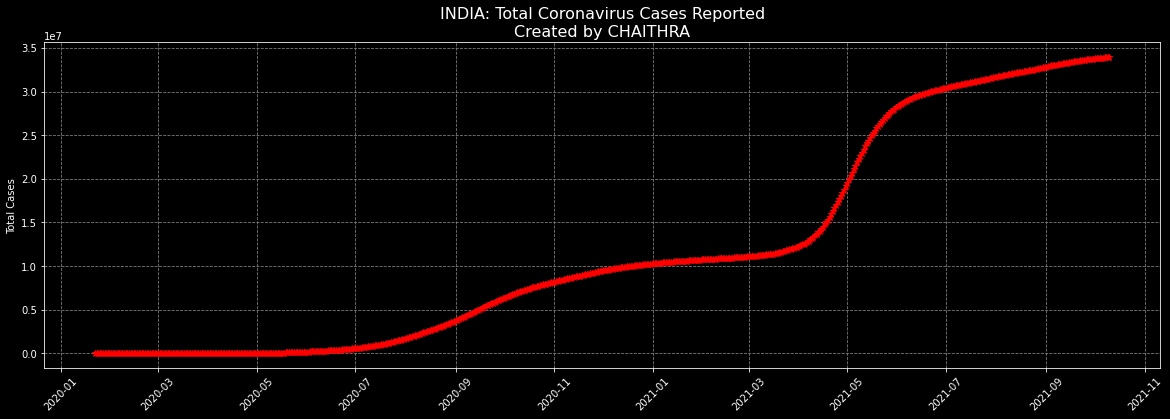

In [ ]:
#Create a line plot for the total confirmed cases in India using the 'line_plot()' function.
line_plot("Chaithra","dark_background",20,6,"India","red",2,'*')

**Note:** The `line_plot()`

---

####Map^^

Let's create a map for India. For this, we are going to use a dataset showing state-wise data for India. To view the first five rows for the total confirmed cases in India, call the `head()` function on the `india_df` variable which stores the data.

In [ ]:
#List the first five rows of the dataset containing the total number of confirmed cases in India. 
india_df.head(35)

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,Migrated_Other,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes,Latitude,Longitude
1,Andaman and Nicobar Islands,7633,7494,129,10,13/08/2021 23:27:22,0,AN,0,0,0,NaN,12.611239,92.831654
2,Andhra Pradesh,2057562,2036048,14256,7258,13/08/2021 23:27:22,0,AP,310,994,2,NaN,15.924091,80.186381
3,Arunachal Pradesh,54900,54354,280,266,13/08/2021 23:27:22,0,AR,0,0,0,[July 25]: All numbers corresponding to Papum ...,28.093770,94.592133
4,Assam,604969,595091,5926,2605,13/08/2021 23:27:22,1347,AS,0,0,0,[Jan 1]: 1347 cases i.e Covid +'tive patients ...,26.407384,93.255130
5,Bihar,725996,716300,9661,34,13/08/2021 23:27:22,1,BR,0,0,0,[June 9] : 3951 deceased cases have been repor...,25.644085,85.906508
6,Chandigarh,65279,64421,820,38,13/08/2021 23:27:22,0,CH,0,0,0,NaN,30.733442,76.779714
7,Chhattisgarh,1005530,991755,13570,205,13/08/2021 23:27:22,0,CT,0,0,0,NaN,21.663736,81.840635
8,Dadra and Nagar Haveli and Daman and Diu,10677,10638,4,4,13/08/2021 23:27:22,31,DN,2,0,0,NaN,20.718175,70.932383
9,Delhi,1439218,1413760,25089,369,13/08/2021 23:27:22,0,DL,23,1,0,[July 14]: Value for the total tests conducted...,28.651718,77.221939
10,Goa,177148,173171,3330,647,13/08/2021 23:27:22,0,GA,35,97,1,NaN,15.350319,74.101782


Let's now create a map for India to show the state-wise total confirmed cases of coronavirus. Using the latitude and longitude values (which are numeric values with decimal), we can create circular markers on a map. For this, you need to use the `folium_map_with_circles()` function which takes the following inputs:

- Name of the person who is creating the map which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`).

- Name of the country for which a map needs to be created. It should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`). For the map only three values are supported:

  1. `'India'`

  2. `'US'`

  3. `'World'`

- Width of the map (numeric value).

- Height of the map (numeric value).

- Left margin for the map (numeric value).

- Top margin for the map (numeric value).

- The background style of the map which should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`). Here is the list of most commonly used background styles:

  1. `'OpenStreetMap'`

  2. `'Stamen Terrain'`

  3. `'Stamen Toner'`

- Initial zoom in value (a numeric value)

- Colour of the circles on the map should be a text value enclosed within single-quotes (`''`) or double-quotes (`""`). Here's the list of most commonly used colours:

  1. `'red'`
  
  2. `'blue'` 
  
  3. `'magenta'`

  4. `'yellow'`

  5. `'green'`

- Whether you want the map to have a minimap or not; `True` for **yes** and `False` for **no**.


In [ ]:
#Create a map for India to show the state-wise total confirmed cases of coronavirus.
folium_map_with_circles("Chaithra","India",1000,700,2,2,"Stamen Terrain",5,"blue",True)

---